## Phone Data

In [37]:
import os
import statistics
import csv
import itertools
import keras
import sklearn.linear_model

import pandas as pd
import numpy as np
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn

from tqdm import tqdm_notebook as tqdm
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers import *
from keras.utils import to_categorical
from keras.optimizers import Adam

In [38]:
act_path = "wisdm-dataset/activity_key.txt"
act_file = open(act_path,"r")
act_list = act_file.read().split('\n')
act_map = {}
for elem in act_list:
    split = elem.split(" = ")
    if len(split) < 2:
        continue
    act_map[split[1]] = split[0]
#map of activies: Label : action    
act_map

{'A': 'walking',
 'B': 'jogging',
 'C': 'stairs',
 'D': 'sitting',
 'E': 'standing',
 'F': 'typing',
 'G': 'teeth',
 'H': 'soup',
 'I': 'chips',
 'J': 'pasta',
 'K': 'drinking',
 'L': 'sandwich',
 'M': 'kicking',
 'O': 'catch',
 'P': 'dribbling',
 'Q': 'writing',
 'R': 'clapping',
 'S': 'folding'}

In [39]:
phone = pd.read_pickle('phone.df')

In [40]:
window_size = 100
stride = window_size

frames = []
for i in tqdm(range(0, len(phone)-window_size, stride)):
    window = phone.iloc[i:i+window_size]
    if window['activity'].nunique() == 1:
        frames.append(window)

In [41]:
activities = sorted(act_map.keys())
activity_encoding = {v: k for k, v in enumerate(activities)}

X_list = []
y_list = []

#for each frame replace label with activity
for frame in tqdm(frames):
    X_list.append(frame[['phone_accel_x', 'phone_accel_y', 'phone_accel_z', 'phone_gyro_x', 'phone_gyro_y', 'phone_gyro_z']].values)
    y_list.append(activity_encoding[frame.iloc[0]['activity']])

In [42]:
X = np.array(X_list)
y = np.array(to_categorical(y_list))

In [43]:
print(X.shape)
print(y.shape)

(46906, 100, 6)
(46906, 18)


sandwich


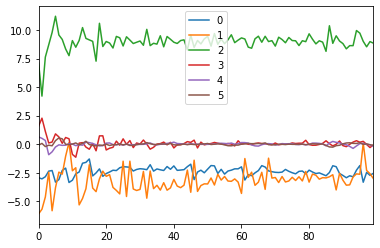

In [44]:
#six datapoints: phone, watch and each has accel and gyros data 
#example: xyz of accel for phone is 0 1 2 
#n is index into the dataframe of the X_list which is list of all of the windows
n = 16000
pd.DataFrame(X_list[n]).plot()

reverse_activity_encoding = {v: act_map[k] for k, v in activity_encoding.items()}
print(reverse_activity_encoding[y_list[n]])

In [45]:
#data split: as informed by slides split for 30,000 examples 
#our example is a window and coming from a big expansive amount of data
#5 second split based on papers using 5 sec split. We can play with this 

X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=42)

#train
print("X_train: ",X_train.shape)

#dev
print("X_val: ",X_val.shape)

#test
print("X_test: ",X_test.shape)

print("Y_train: ",y_train.shape)
print("Y_val: ",y_val.shape)
print("Y_test: ",y_test.shape)

X_train:  (28143, 100, 6)
X_val:  (9381, 100, 6)
X_test:  (9382, 100, 6)
Y_train:  (28143, 18)
Y_val:  (9381, 18)
Y_test:  (9382, 18)


In [46]:
#data split: as informed by slides split for 30,000 examples 
#our example is a window and coming from a big expansive amount of data
#5 second split based on papers using 5 sec split. We can play with this 

X_train_2, X_valtest_2, y_train_2, y_valtest_2 = train_test_split(X, y, test_size=0.1, random_state=42)
X_val_2, X_test_2, y_val_2, y_test_2 = train_test_split(X_valtest_2, y_valtest_2, test_size=0.1, random_state=42)

#train
print("X_train_2: ",X_train_2.shape)

#dev
print("X_val_2: ",X_val_2.shape)

#test
print("X_test_2: ",X_test_2.shape)

print("Y_train_2: ",y_train_2.shape)
print("Y_val_2: ",y_val_2.shape)
print("Y_test_2: ",y_test_2.shape)

X_train_2:  (42215, 100, 6)
X_val_2:  (4221, 100, 6)
X_test_2:  (470, 100, 6)
Y_train_2:  (42215, 18)
Y_val_2:  (4221, 18)
Y_test_2:  (470, 18)


## LogReg Baseline

In [47]:
lrModel = sklearn.linear_model.LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
X_train_flattened = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
print("X: ",X_train_flattened.shape)
lrModel.fit(X_train_flattened, y_train.argmax(axis=1))

X:  (28143, 600)


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [52]:
lrModel2 = sklearn.linear_model.LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial')
X_train_flattened_2 = X_train_2.reshape((X_train_2.shape[0], X_train_2.shape[1] * X_train_2.shape[2]))
print("X2: ",X_train_flattened_2.shape)
lrModel2.fit(X_train_flattened_2, y_train_2.argmax(axis=1))

X2:  (42215, 600)


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [49]:
#logreg results
predictions = lrModel.predict(X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2]))
score = lrModel.score(X_val.reshape(X_val.shape[0], X_val.shape[1]*X_val.shape[2]), y_val.argmax(axis=1))
print(score)

0.13761859076857477


In [53]:
#logreg results
predictions2 = lrModel2.predict(X_val_2.reshape(X_val_2.shape[0], X_val_2.shape[1]*X_val_2.shape[2]))
score2 = lrModel2.score(X_val_2.reshape(X_val_2.shape[0], X_val_2.shape[1]*X_val_2.shape[2]), y_val_2.argmax(axis=1))
print("X2 score: ", score2)

X2 score:  0.11537550343520493


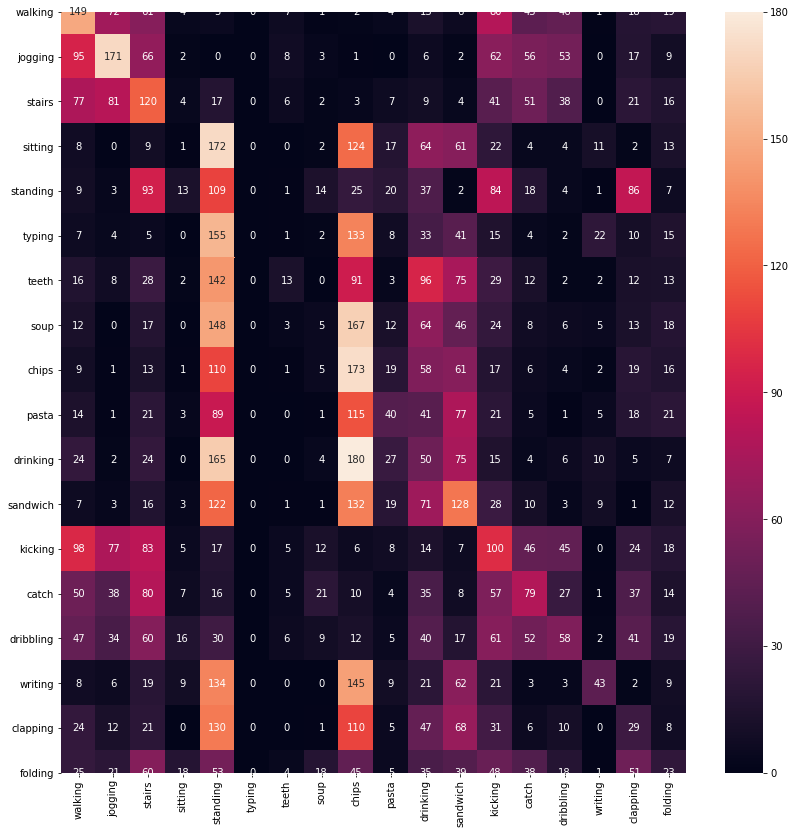

In [54]:
#As you can see: there's a locality of mispredictions around sports (kickingm catch, dribbling)
cm = confusion_matrix(y_val.argmax(axis=1), predictions)
df_cm = pd.DataFrame(cm, index = [reverse_activity_encoding[i] for i in range(18)], columns = [reverse_activity_encoding[i] for i in range(18)])
plt.figure(figsize = (14,14))
sn.heatmap(df_cm, annot=True, fmt='g')

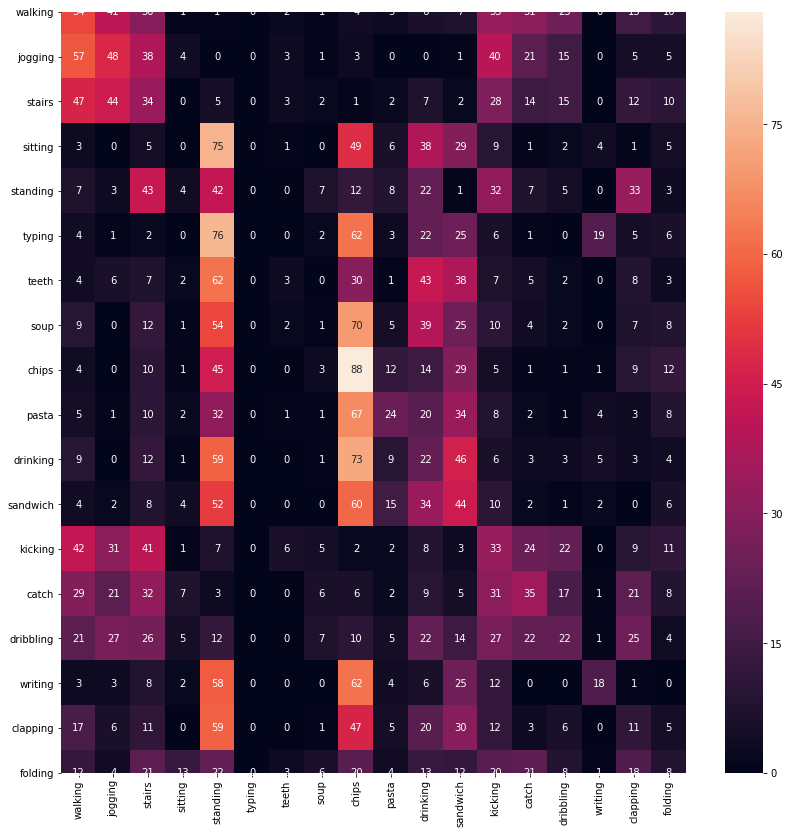

In [56]:
#As you can see: there's a locality of mispredictions around sports (kickingm catch, dribbling)
cm2 = confusion_matrix(y_val_2.argmax(axis=1), predictions2)
df_cm2 = pd.DataFrame(cm2, index = [reverse_activity_encoding[i] for i in range(18)], columns = [reverse_activity_encoding[i] for i in range(18)])
plt.figure(figsize = (14,14))
sn.heatmap(df_cm2, annot=True, fmt='g')

In [59]:
#Model 

model = Sequential()

model.add(Conv1D(8, 3, activation='relu', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(16, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(32, 3, activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, 3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

# keras.utils.plot_model(
#     model,
#     to_file='model_plot_4-ConvLayer.png',
#     show_shapes=True,
#     show_layer_names=True,
# )

model.summary()



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 98, 8)             152       
_________________________________________________________________
batch_normalization_13 (Batc (None, 98, 8)             32        
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 49, 8)             0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 47, 16)            400       
_________________________________________________________________
batch_normalization_14 (Batc (None, 47, 16)            64        
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 23, 16)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 21, 32)           

In [60]:
#Model .1 /.1 split

model2 = Sequential()

model2.add(Conv1D(8, 3, activation='relu', input_shape=X_train.shape[1:]))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(pool_size=2))

model2.add(Conv1D(16, 3, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(pool_size=2))

model2.add(Conv1D(32, 3, activation='relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling1D(pool_size=2))

model2.add(Conv1D(64, 3, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling1D(pool_size=2))

model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(y_train.shape[1], activation='softmax'))

# keras.utils.plot_model(
#     model,
#     to_file='model_plot_4-ConvLayer.png',
#     show_shapes=True,
#     show_layer_names=True,
# )

model2.summary()



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 98, 8)             152       
_________________________________________________________________
batch_normalization_17 (Batc (None, 98, 8)             32        
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 49, 8)             0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 47, 16)            400       
_________________________________________________________________
batch_normalization_18 (Batc (None, 47, 16)            64        
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 23, 16)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 21, 32)           

In [61]:
#loss function: using cross entropy
model.compile(Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['acc'])

In [62]:
#loss function: using cross entropy
model2.compile(Adam(),
              loss=keras.losses.categorical_crossentropy,
              metrics=['acc'])

In [63]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), verbose=1)

Train on 28143 samples, validate on 9381 samples
Epoch 1/20
28143/28143 [==============================] - 18s 649us/step - loss: 2.1716 - acc: 0.2537 - val_loss: 1.9188 - val_acc: 0.3296
Epoch 2/20
28143/28143 [==============================] - 15s 543us/step - loss: 1.9183 - acc: 0.3280 - val_loss: 1.8159 - val_acc: 0.3553
Epoch 3/20
28143/28143 [==============================] - 15s 543us/step - loss: 1.8166 - acc: 0.3592 - val_loss: 1.7378 - val_acc: 0.3929
Epoch 4/20
28143/28143 [==============================] - 15s 550us/step - loss: 1.7472 - acc: 0.3856 - val_loss: 1.6729 - val_acc: 0.4091
Epoch 5/20
28143/28143 [==============================] - 15s 531us/step - loss: 1.6878 - acc: 0.4019 - val_loss: 1.6038 - val_acc: 0.4316
Epoch 6/20
28143/28143 [==============================] - 16s 559us/step - loss: 1.6251 - acc: 0.4249 - val_loss: 1.5644 - val_acc: 0.4500
Epoch 7/20
28143/28143 [==============================] - 15s 540us/step - loss: 1.5883 - acc: 0.4362 - val_loss: 1.5

In [64]:
history2 = model2.fit(X_train_2, y_train_2, epochs=20, validation_data=(X_val_2, y_val_2), verbose=1)

Train on 42215 samples, validate on 4221 samples
Epoch 1/20
42215/42215 [==============================] - 25s 588us/step - loss: 2.0909 - acc: 0.2725 - val_loss: 1.8203 - val_acc: 0.3459
Epoch 2/20
42215/42215 [==============================] - 21s 504us/step - loss: 1.8381 - acc: 0.3506 - val_loss: 1.7139 - val_acc: 0.4129
Epoch 3/20
42215/42215 [==============================] - 21s 496us/step - loss: 1.7370 - acc: 0.3887 - val_loss: 1.6329 - val_acc: 0.4179
Epoch 4/20
42215/42215 [==============================] - 21s 504us/step - loss: 1.6617 - acc: 0.4115 - val_loss: 1.5839 - val_acc: 0.4324
Epoch 5/20
42215/42215 [==============================] - 21s 500us/step - loss: 1.6150 - acc: 0.4282 - val_loss: 1.4894 - val_acc: 0.4693
Epoch 6/20
42215/42215 [==============================] - 21s 496us/step - loss: 1.5679 - acc: 0.4442 - val_loss: 1.4772 - val_acc: 0.4793
Epoch 7/20
42215/42215 [==============================] - 21s 496us/step - loss: 1.5245 - acc: 0.4592 - val_loss: 1.4

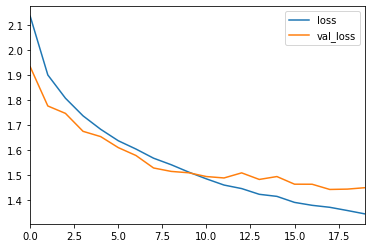

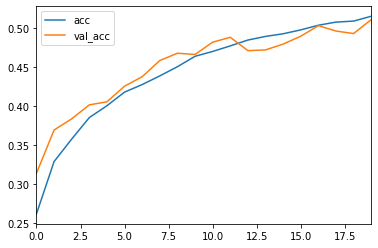

In [16]:
metrics_history = pd.DataFrame(history.history)
metrics_history[['loss', 'val_loss']].plot() #loss = train loss, val_loss = validation Loss
metrics_history[['acc', 'val_acc']].plot() # acc = train acc, val_acc = validation acc

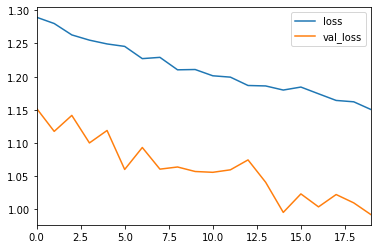

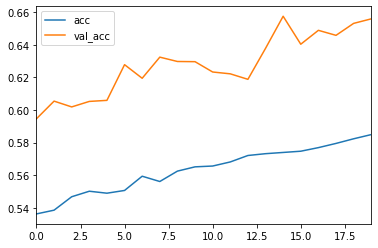

In [30]:
metrics_history_2 = pd.DataFrame(history2.history)
metrics_history_2[['loss', 'val_loss']].plot() #loss = train loss, val_loss = validation Loss
metrics_history_2[['acc', 'val_acc']].plot() # acc = train acc, val_acc = validation acc

In [17]:
y_val_pred = model.predict(X_val)

y_val_argmax = y_val.argmax(axis=1)
y_val_pred_argmax = y_val_pred.argmax(axis=1)

actual_val_activities = [reverse_activity_encoding[i] for i in y_val_argmax]
predicted_val_activities = [reverse_activity_encoding[i] for i in y_val_pred_argmax]

In [31]:
y_val_pred_2 = model.predict(X_val_2)

y_val_argmax_2 = y_val_2.argmax(axis=1)
y_val_pred_argmax_2 = y_val_pred_2.argmax(axis=1)

actual_val_activities_2 = [reverse_activity_encoding[i] for i in y_val_argmax_2]
predicted_val_activities_2 = [reverse_activity_encoding[i] for i in y_val_pred_argmax_2]

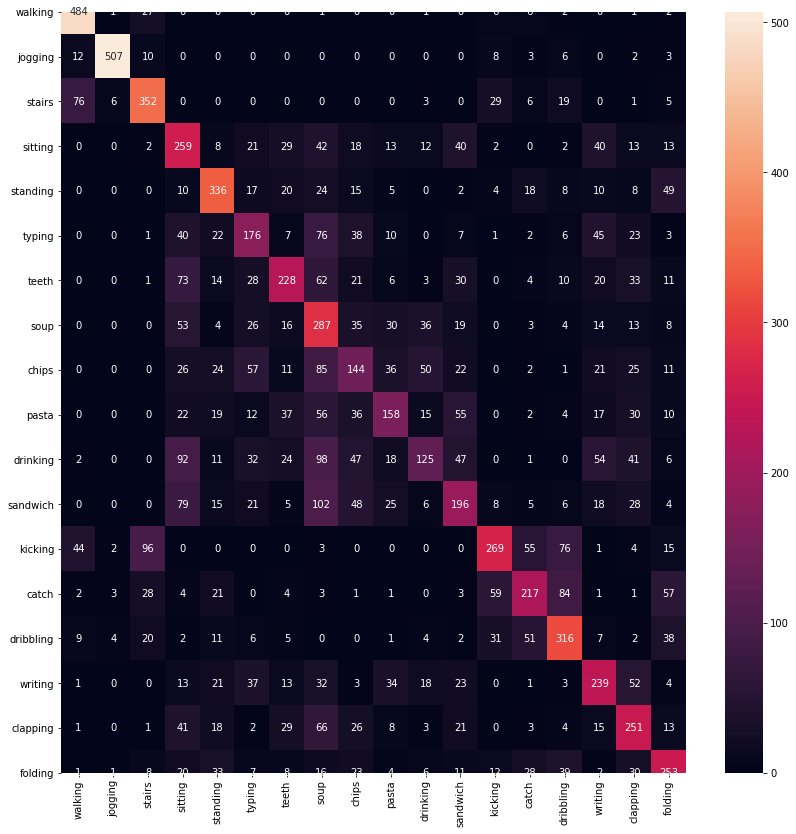

In [18]:
cm = confusion_matrix(y_val_argmax, y_val_pred_argmax)
df_cm = pd.DataFrame(cm, index = [reverse_activity_encoding[i] for i in range(18)], columns = [reverse_activity_encoding[i] for i in range(18)])
plt.figure(figsize = (14,14))
sn.heatmap(df_cm, annot=True, fmt='g')

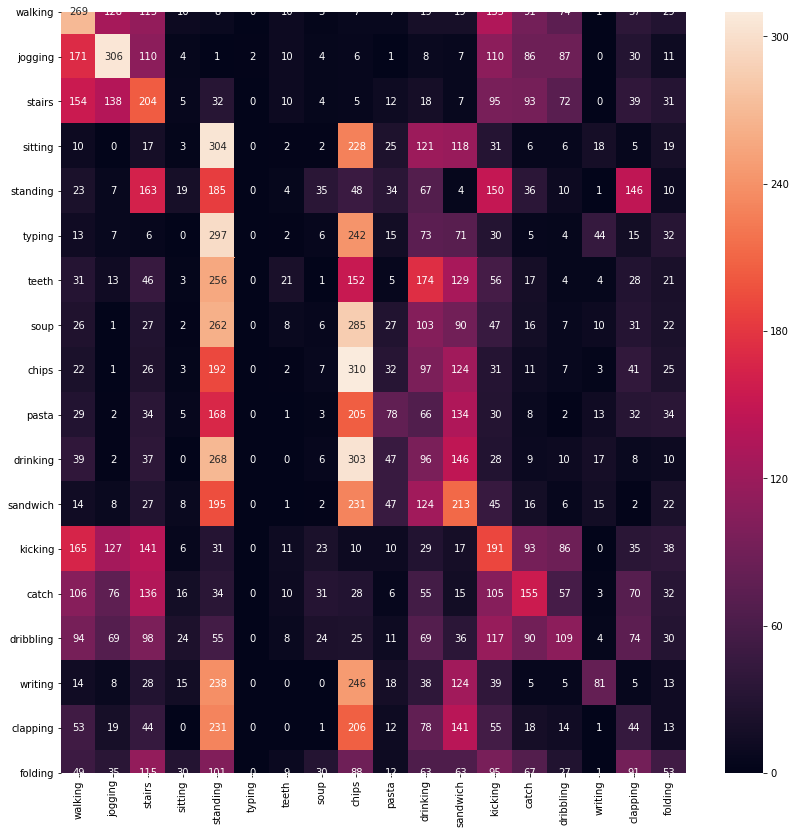

In [32]:
cm2 = confusion_matrix(y_val_argmax_2, y_val_pred_argmax_2)
df_cm_2 = pd.DataFrame(cm, index = [reverse_activity_encoding[i] for i in range(18)], columns = [reverse_activity_encoding[i] for i in range(18)])
plt.figure(figsize = (14,14))
sn.heatmap(df_cm_2, annot=True, fmt='g')